In [9]:
import numpy as np
from groundlight import Groundlight
import glob
import cv2
import matplotlib.pyplot as plt
import matplotlib
import os
import PIL
from PIL import Image
from io import BytesIO
np.random.seed(0)

In [2]:
# # Load the API client. This defaults to the prod endpoint,
# # but you can specify a different endpoint like so:
# #gl = Groundlight(endpoint="https://device.integ.positronix.ai/device-api")

# GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'

# gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)

# # Call an API method (e.g., retrieve a list of detectors)
# detectors = gl.list_detectors()

# det = detectors.results[1]

# print(det)

id='det_2AuDZFz06xbytjWrTL0dUvsjOz7' type=<DetectorTypeEnum.detector: 'detector'> created_at=datetime.datetime(2022, 6, 21, 15, 30, 29, 961429, tzinfo=tzoffset(None, -25200)) name='newRubiksCube' query="Is entire Rubik's cube contained within image?" group_name='__DEFAULT' confidence_threshold=0.5


In [3]:
def sweepLocalize(det, img):
    
    imgDims = np.array([img.shape[1],img.shape[0]])
    
    #Recursive Base Case, i.e. too many splits
    if imgDims[0] < 20 or imgDims[1] < 20:
        return None
    
    kernelDims = (imgDims*2/3).astype(int)
    sweepDims = (imgDims/4).astype(int)
    colSweeps, rowSweeps = np.round(imgDims/sweepDims).astype(int) - 1
    
    fig, ax = plt.subplots(rowSweeps, colSweeps, figsize = (16,12))
    
    sliceConfidences = np.zeros((rowSweeps, colSweeps))
    sliceDict = {}
    
    for col in range(colSweeps):
        for row in range(rowSweeps):
            pxStart = sweepDims * np.array([col, row])
            pxEnd = pxStart + kernelDims
            
            sliceDict[(row, col)] = (pxStart, pxEnd)
            
            sliceImgMat = img[pxStart[1]:pxEnd[1],pxStart[0]:pxEnd[0],:]
            
            sliceImgPIL = Image.fromarray(cv2.cvtColor(sliceImgMat, cv2.COLOR_BGR2RGB))
            byte_io = BytesIO()
            
            sliceImgPIL.save(byte_io, 'jpeg')
            jpg_buffer = byte_io.getvalue()
            byte_io.close()
            
            image_query = gl.submit_image_query(detector_id=det.id, image = jpg_buffer)
            
            sliceLabel = image_query.result.label
            sliceConf = image_query.result.confidence
            
            if sliceLabel == 'PASS':
                ax[row, col].set_title('cube found, conf: '+ str(np.round(sliceConf,2)))
                ax[row, col].imshow(sliceImgMat)
                sliceConfidences[row, col] = sliceConf
            else:
                ax[row, col].imshow(cv2.cvtColor(sliceImgMat,cv2.COLOR_BGR2GRAY), cmap = 'ocean')
                sliceConfidences[row, col] = 0
                
    max1dInd = np.argmax(sliceConfidences)
    max2dInd = np.unravel_index(max1dInd, sliceConfidences.shape)
    
    bestConf = sliceConfidences[max2dInd]
    
    if bestConf < 0.65:
        return None
    
    ax[max2dInd[0], max2dInd[1]].set_title('CUBE FOUND, BEST CONF: ' + str(np.round(bestConf,2)), fontsize = 15, color = 'lime')
    
    bestPxStart, bestPxEnd = sliceDict[max2dInd]
    
    bestSliceImgMat = img[bestPxStart[1]:bestPxEnd[1],bestPxStart[0]:bestPxEnd[0],:]
    
    plt.show()
    
    return (bestPxStart, np.minimum(bestPxEnd, imgDims), sweepLocalize(det, bestSliceImgMat))

In [8]:
def assemblePxTreeHelper(oldPx, tree):
    newPx = oldPx + tree[0]
    if(tree[2]) is None:
        newPx += ((tree[1] - tree[0])/2).astype(int)
        return newPx
    return assemblePxTreeHelper(newPx, tree[2])

def assemblePxTree(tree):
    return assemblePxTreeHelper(np.array([0,0]), tree)

In [5]:
def plotTreeOnImage(tree, img):
    fig, ax = plt.subplots(1,1, figsize = (10,8))
    ax.imshow(img)
    plotTreeOnImageHelper(ax, tree, np.array([0,0]))
    return fig, ax
                           
def plotTreeOnImageHelper(ax, tree, prevPx):
    
    cmap = matplotlib.cm.get_cmap('rainbow')
    
    if tree[2] is None:
        center = prevPx + ((tree[0] + tree[1])/2).astype(int)
        ax.scatter([center[0]], [center[1]], marker = 'x', s = 60, color = 'black')
        return
    
    color = cmap(np.random.rand())
    ax.scatter([tree[0][0] + prevPx[0]],[tree[0][1]  + prevPx[1]],marker = 'o', s = 30, color = color)
    ax.scatter([tree[1][0]  + prevPx[0]],[tree[1][1]  + prevPx[1]],marker = 'o', s = 30, color = color)
    prevPx += tree[0]
    plotTreeOnImageHelper(ax, tree[2], prevPx)

In [325]:
# allCubeImgs = sorted(glob.glob(imgDir + "*"))
# imgName = allCubeImgs[10]
# img = cv2.imread(imgName)
# img = cv2.resize(img, (640,480))

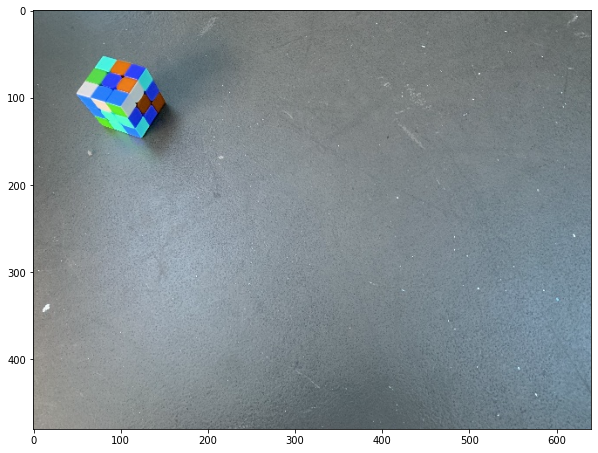

In [327]:
# plt.figure(figsize = (10,8))
# plt.imshow(img)
# plt.show()

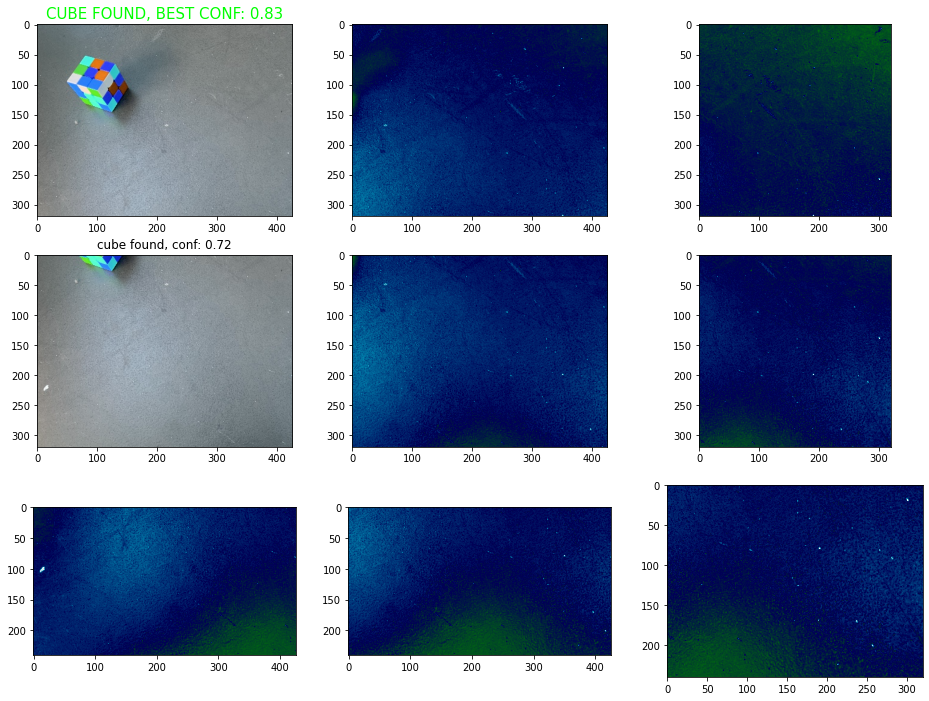

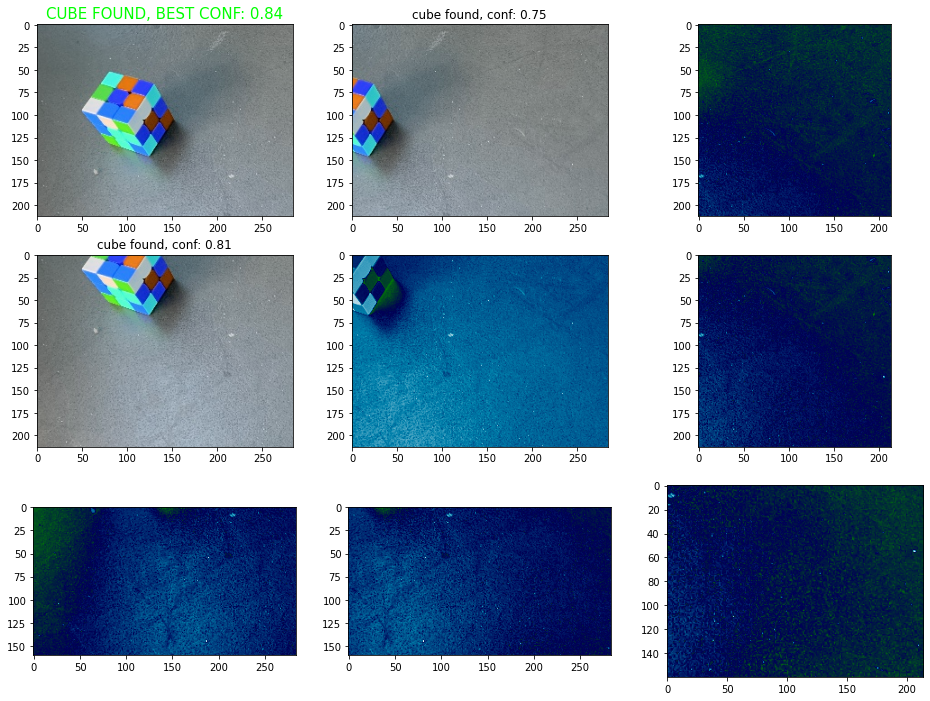

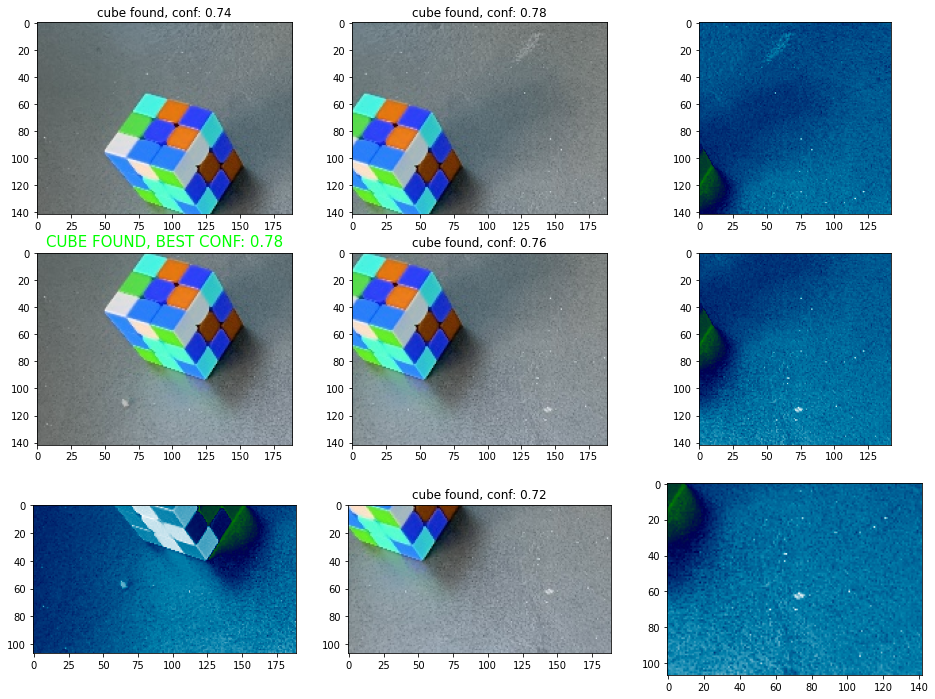

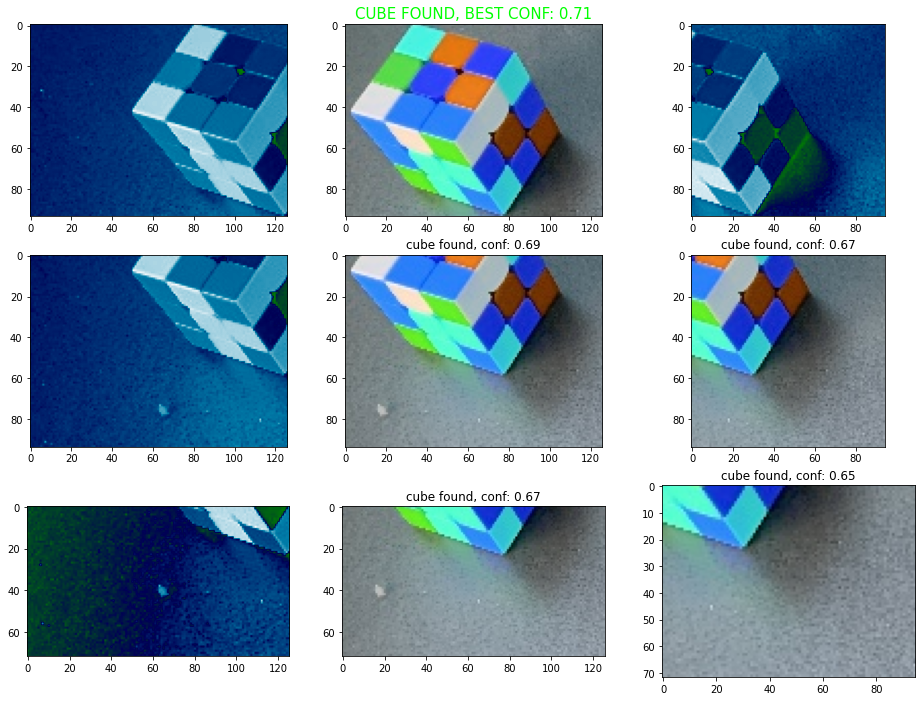

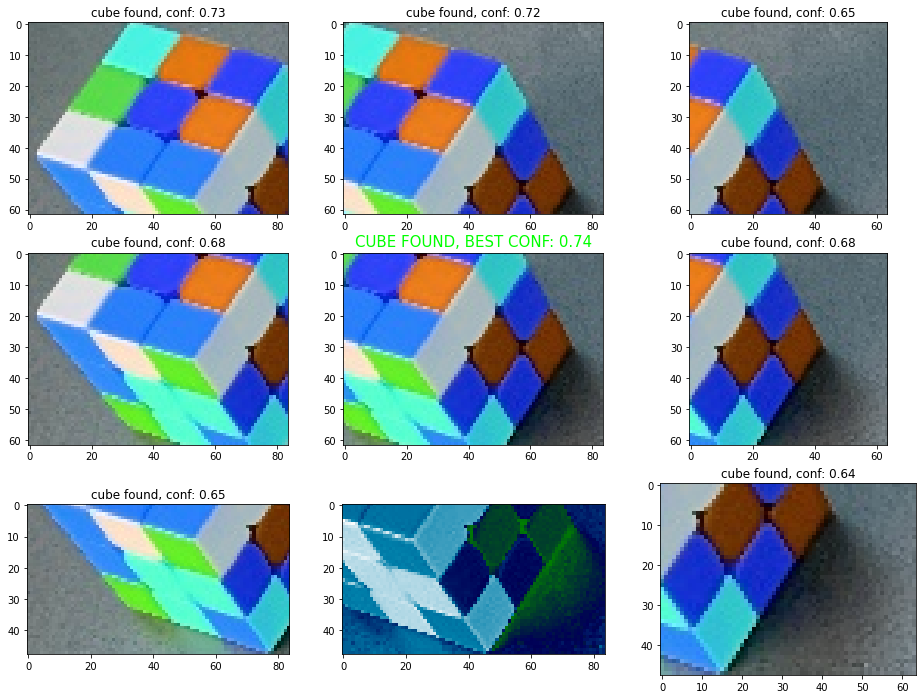

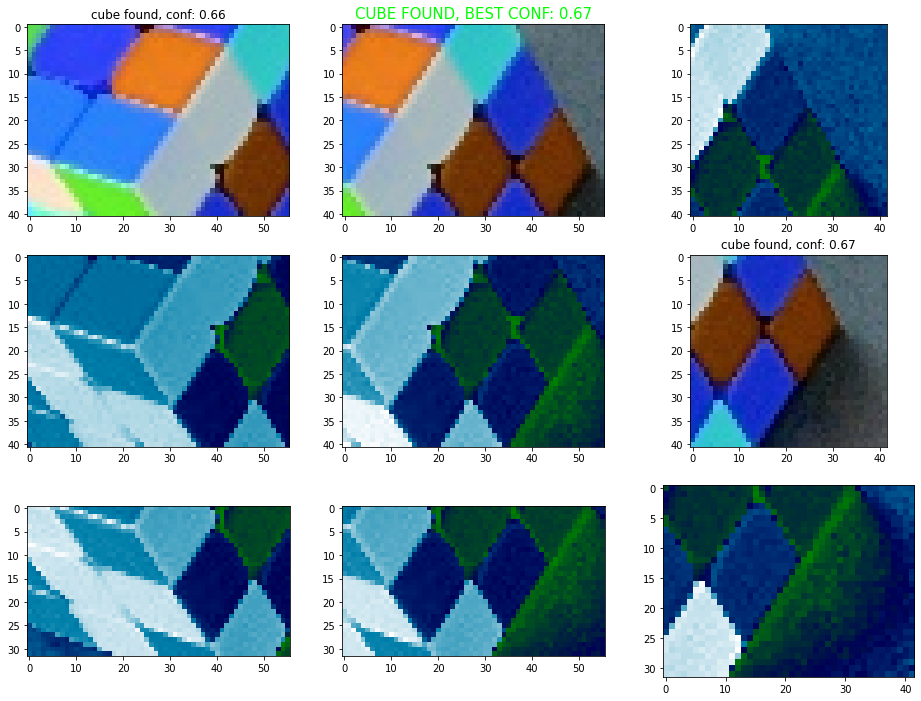

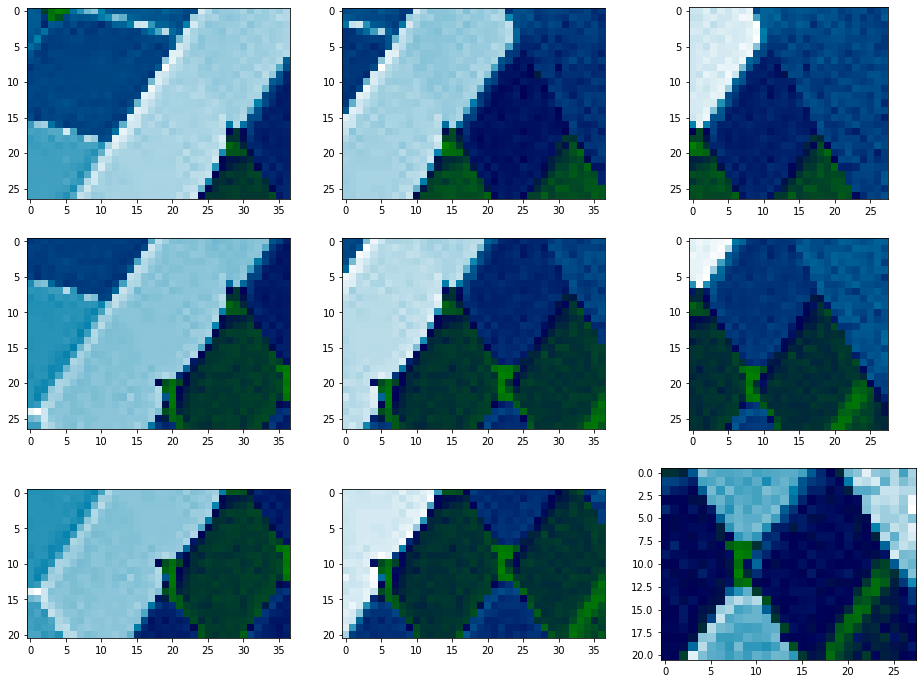

In [328]:
# tree = sweepLocalize(det, img)

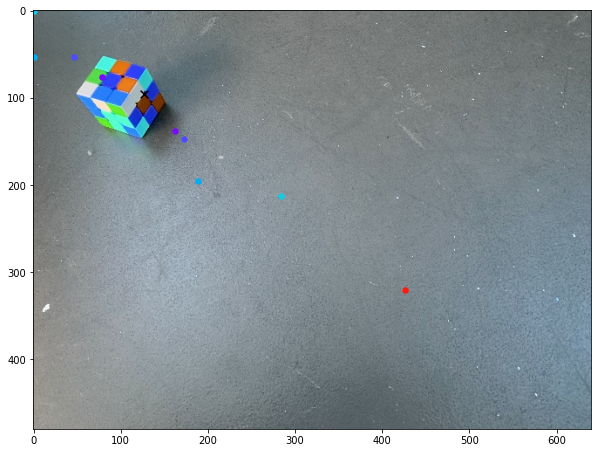

In [329]:
# plotTreeOnImage(tree, img)
# plt.show()

In [47]:
# sliceName = rootDir + 'images/cubes/slices/196./sliceImgMat01.jpg'
# image_query = gl.submit_image_query(detector_id=det.id, image = sliceName)

In [ ]:
# imgDims = np.array([640,480])

# imgDir = '/Users/agoutam/Documents/groundlight/glAPI/images/cubes/training/'
# allCubeImgs = [path.split('/')[-1] for path in glob.glob(imgDir+ '*')]
# imgName = allCubeImgs[0]


# allOriginalNames = glob.glob('/Users/agoutam/Documents/groundlight/glAPI/images/cubes/originals/*')

# for origName in allOriginalNames:
#     print(origName)
#     img = cv2.imread(origName)
#     img = cv2.resize(img, dsize = (640,480))
#     newImgName = '/Users/agoutam/Documents/groundlight/glAPI/images/cubes/training/' + origName.split('/')[-1]
#     print(newImgName)
#     cv2.imwrite(newImgName, img)